In [1]:
import os
import torch
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
import torch.nn as nn
from google.colab import drive
import gdown
import json

# ----------------------------------------
# Check GPU
# ----------------------------------------
print("GPU Available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

-------------------
!pip install -q torch torchvision kaggle gdown

GPU Available: True
GPU Name: Tesla T4
Using device: cuda


In [ ]:
# ----------------------------------------
# Step 1: Install and import required packages
# (if using Colab, some packages like kaggle may need to be installed first)
# ----------------------------------------
!pip install kaggle --quiet  # Install Kaggle API client
!pip install umap-learn --quiet  # For UMAP dimensionality reduction

import os  # For file and directory operations
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical operations
from sklearn.preprocessing import StandardScaler  # For scaling gene expression data

In [2]:
# Setup Kaggle API (environment variables recommended)
# ----------------------------------------
os.environ["KAGGLE_USERNAME"] = "your_username"
os.environ["KAGGLE_KEY"] = "your_api_key"
kaggle_username = os.environ.get("KAGGLE_USERNAME")
kaggle_key      = os.environ.get("KAGGLE_KEY")
if kaggle_username and kaggle_key:
    os.makedirs("/root/.kaggle", exist_ok=True)
    with open("/root/.kaggle/kaggle.json", "w") as f:
        json.dump({"username": kaggle_username, "key": kaggle_key}, f)
    os.chmod("/root/.kaggle/kaggle.json", 0o600)
    !kaggle -v
else:
    print("⚠️ Kaggle credentials not set. Set KAGGLE_USERNAME and KAGGLE_KEY env variables.")




Kaggle API 1.7.4.5


In [3]:
# Download METABRIC breast cancer dataset from Kaggle
# Dataset contains gene expression and clinical data
# ----------------------------------------
!kaggle datasets download -d raghadalharbi/breast-cancer-gene-expression-profiles-metabric

# Step 4: Unzip the downloaded dataset
# This will extract CSV or TSV files for further analysis
!unzip breast-cancer-gene-expression-profiles-metabric.zip

Dataset URL: https://www.kaggle.com/datasets/raghadalharbi/breast-cancer-gene-expression-profiles-metabric
License(s): DbCL-1.0
  0% 0.00/2.72M [00:00<?, ?B/s]
100% 2.72M/2.72M [00:00<00:00, 795MB/s]
Archive:  breast-cancer-gene-expression-profiles-metabric.zip
  inflating: METABRIC_RNA_Mutation.csv  


In [5]:
#Load clinical and gene expression data
# Assume files are named 'clinical.csv' and 'gene_expression.csv' after extraction

clinical = pd.read_csv("METABRIC_RNA_Mutation.csv")
clinical.head()


/tmp/ipython-input-4154019715.py:3: DtypeWarning: Columns (678,688,690,692) have mixed types. Specify dtype option on import or set low_memory=False.
  clinical = pd.read_csv("METABRIC_RNA_Mutation.csv")


,patient_id,age_at_diagnosis,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,...,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
0,0,75.65,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,0,claudin-low,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
1,2,43.19,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumA,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
2,5,48.87,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
3,6,47.68,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
4,8,76.97,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0


In [6]:
!ls


breast-cancer-gene-expression-profiles-metabric.zip  sample_data
METABRIC_RNA_Mutation.csv


In [9]:


df = pd.read_csv("METABRIC_RNA_Mutation.csv")
df.head()


/tmp/ipython-input-1034879137.py:3: DtypeWarning: Columns (678,688,690,692) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("METABRIC_RNA_Mutation.csv")


,patient_id,age_at_diagnosis,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,...,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
0,0,75.65,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,0,claudin-low,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
1,2,43.19,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumA,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
2,5,48.87,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
3,6,47.68,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
4,8,76.97,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0


In [10]:
df.columns


Index(['patient_id', 'age_at_diagnosis', 'type_of_breast_surgery',
       'cancer_type', 'cancer_type_detailed', 'cellularity', 'chemotherapy',
       'pam50_+_claudin-low_subtype', 'cohort', 'er_status_measured_by_ihc',
       ...
       'mtap_mut', 'ppp2cb_mut', 'smarcd1_mut', 'nras_mut', 'ndfip1_mut',
       'hras_mut', 'prps2_mut', 'smarcb1_mut', 'stmn2_mut', 'siah1_mut'],
      dtype='object', length=693)

In [11]:
clinical_cols = [
    "age_at_diagnosis",
    "overall_survival",
    "overall_survival_months",
    "cancer_type_detailed"
]

clinical = df[clinical_cols].dropna()
clinical.head()


,age_at_diagnosis,overall_survival,overall_survival_months,cancer_type_detailed
0,75.65,1,140.500000,Breast Invasive Ductal Carcinoma
1,43.19,1,84.633333,Breast Invasive Ductal Carcinoma
2,48.87,0,163.700000,Breast Invasive Ductal Carcinoma
3,47.68,1,164.933333,Breast Mixed Ductal and Lobular Carcinoma
4,76.97,0,41.366667,Breast Mixed Ductal and Lobular Carcinoma


In [12]:

# Select only gene expression columns
# Assume gene expression starts from column index 31 onwards
# Align rows with the clinical data
# ----------------------------------------
gene_expression = df.iloc[:, 31:]
gene_expression = gene_expression.loc[clinical.index]
# Preview the first 5 rows
gene_expression.head()


,brca1,brca2,palb2,pten,tp53,atm,cdh1,chek2,nbn,nf1,...,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
0,-1.3990,-0.5738,-1.6217,1.4524,0.3504,1.1517,0.0348,0.1266,-0.8361,-0.8578,...,0,0,0,0,0,0,0,0,0,0
1,-1.3800,0.2777,-1.2154,0.5296,-0.0136,-0.2659,1.3594,0.7961,0.5419,-2.6059,...,0,0,0,0,0,0,0,0,0,0
2,0.0670,-0.8426,0.2114,-0.3326,0.5141,-0.0803,1.1398,0.4187,-0.4030,-1.1305,...,0,0,0,0,0,0,0,0,0,0
3,0.6744,-0.5428,-1.6592,0.6369,1.6708,-0.8880,1.2491,-1.1889,-0.4174,-0.6165,...,0,0,0,0,0,0,0,0,0,0
4,1.2932,-0.9039,-0.7219,0.2168,0.3484,0.3897,0.9131,0.9356,0.7675,-0.2940,...,0,0,0,0,0,0,0,0,0,0


In [13]:
gene_expression.dtypes.value_counts()

,count
float64,489
object,173


In [14]:

# Keep only numeric gene expression columns
gene_expression_numeric = gene_expression.select_dtypes(include=["int64", "float64"])
gene_expression_numeric.shape


(1889, 489)

In [15]:
gene_expression_numeric = gene_expression_numeric.dropna(axis=1)# Drop columns with NaNs


In [16]:

# ----------------------------------------
# Scale gene expression data
# StandardScaler centers the data (mean=0) and scales to unit variance
# ----------------------------------------
scaler = StandardScaler()
X_genes_scaled = scaler.fit_transform(gene_expression_numeric)


In [ ]:


# Copy clinical data to create age groups
clinical_age = clinical.copy()

clinical_age["age_group"] = np.nan
clinical_age.loc[clinical_age["age_at_diagnosis"] <= 40, "age_group"] = "Early"
clinical_age.loc[clinical_age["age_at_diagnosis"] >= 60, "age_group"] = "Late"

# Keep only Early and Late age groups
mask = clinical_age["age_group"].isin(["Early", "Late"])
clinical_age = clinical_age[mask]
gene_expression_age = gene_expression_numeric.loc[clinical_age.index]

clinical_age["age_group"].value_counts()


/tmp/ipython-input-2152411666.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Early' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  clinical_age.loc[clinical_age["age_at_diagnosis"] <= 40, "age_group"] = "Early"


,count
age_group,
Late,1054
Early,116


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(gene_expression_age)


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


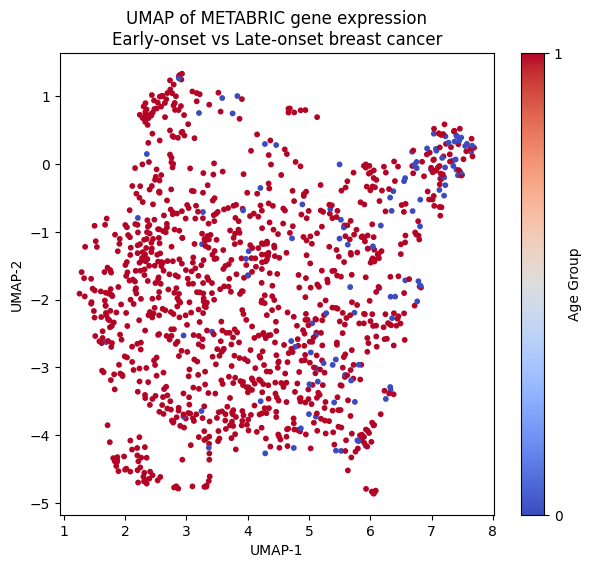

In [ ]:
# UMAP dimensionality reduction for visualization

import umap.umap_ as umap
import matplotlib.pyplot as plt

embedding = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    random_state=42
).fit_transform(X_scaled)
# Map age groups to numeric for coloring in plot
colors = clinical_age["age_group"].map({"Early": 0, "Late": 1})
# Scatter plot of UMAP embedding
plt.figure(figsize=(7,6))
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=colors,
    cmap="coolwarm",
    s=10
)
plt.colorbar(ticks=[0,1], label="Age Group")
plt.title("UMAP of METABRIC gene expression\nEarly-onset vs Late-onset breast cancer")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.show()


In [ ]:
# Statistical comparison: t-test between Early and Late groups
from scipy.stats import ttest_ind
# Create boolean masks for each age group
early_idx = clinical_age["age_group"] == "Early"
late_idx  = clinical_age["age_group"] == "Late"
# Subset gene expression by group
X_early = gene_expression_age[early_idx]
X_late  = gene_expression_age[late_idx]
# Perform independent t-test for each gene
t_stats, p_vals = ttest_ind(X_early, X_late, axis=0, equal_var=False)
# Create DataFrame with results and sort by p-value
deg_results = pd.DataFrame({
    "gene": gene_expression_age.columns,
    "t_stat": t_stats,
    "p_value": p_vals
}).sort_values("p_value")

deg_results.head(10)# Show top 10 significant genes


,gene,t_stat,p_value
280,gata3,-10.074693,3.865808e-18
302,mapt,-9.144718,6.104114e-16
133,bmpr1b,-8.732510,2.241912e-15
375,npnt,-8.767751,3.355825e-15
142,chek1,8.767919,8.780385e-15
59,aph1b,-8.608365,1.331341e-14
434,ar,-8.496761,2.839925e-14
70,dtx3,-8.049387,2.361386e-13
443,cyp21a2,-7.944940,3.271381e-13
31,cdk6,7.955187,6.454754e-13


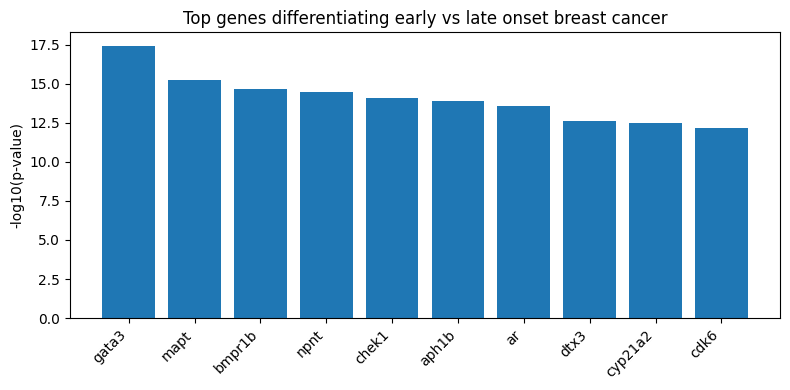

In [ ]:
# Plot top genes differentiating Early vs Late onset
top_genes = deg_results.head(10)["gene"].values

plt.figure(figsize=(8,4))
plt.bar(top_genes, -np.log10(deg_results.head(10)["p_value"]))
plt.xticks(rotation=45, ha="right")
plt.ylabel("-log10(p-value)")
plt.title("Top genes differentiating early vs late onset breast cancer")
plt.tight_layout()
plt.show()
